### เริ่มต้นด้วยการ Install Dependencies

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import os
mydir = "/content/drive/MyDrive/KMUTT/CPE393_TextAnalytics/text_clustering"
os.chdir(mydir)
!ls

consumer_complaint_dataset.data  menuitems.csv	   restaurants_clustered.csv
main.ipynb			 requirements.txt


In [18]:
%pip install -r requirements.txt

In [19]:
import re
import pandas as pd
import numpy as np

from sentence_transformers import SentenceTransformer

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from matplotlib import pyplot as plt

from collections import Counter

### ทำการ Import data เข้ามาเป็น Dataframe

In [45]:
DATA = 'consumer_complaint_dataset.data'
df = pd.read_pickle(DATA, compression='gzip')

In [46]:
df.head()

,topic,input
0,Debt collection,transworld systems inc. \nis trying to collect...
1,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...
2,Debt collection,"Over the past 2 weeks, I have been receiving e..."
3,"Credit reporting, credit repair services, or o...",I HAD FILED WITH CFPB ON XX/XX/XXXX19 TO HAVE ...
4,"Credit reporting, credit repair services, or o...",I have several accounts that the balance is in...


In [47]:
# Dataframe columns: (ทำการประกาศตัวแปร)
TOPIC = 'topic'
COMPLAINT = 'input'
EMBEDDING = 'Embedding'
CLUSTER = 'Cluster'

### Data cleaning

เราจะทำการลบ ตัวอักษรที่ไม่จำเป็นออก ยกตัวอย่าง เช่น Stopwords และ ข้อความที่เขียนและไม่สามารถอ่านออก

* ทำการเอา stopwords ภาษาอังกฤษ จาก Library NLTK

In [48]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [49]:
from nltk.corpus import stopwords
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

* ทำการเขียน Regex เพื่อคัดข้อความให้มีคุณภาพ

In [50]:
import re

REPLACE_BY_SPLACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    # Keep only alphabetical characters
ALPHA_RE = re.compile(r'[^a-zA-Z]')
STOPWORDS = set(stopwords.words('english'))

In [51]:
def clean_text(text):
  text = text.lower()
  text = REPLACE_BY_SPLACE_RE.sub(' ', text)
  text = BAD_SYMBOLS_RE.sub('', text)
  text = ALPHA_RE.sub(' ', text)
  text = text.replace('x', '')
  text = ' '.join(word for word in text.split() if word not in STOPWORDS)
  return text

In [52]:
df[COMPLAINT] = df[COMPLAINT].apply(lambda x: clean_text(x))
df[COMPLAINT] = df[COMPLAINT].str.replace('\d+', '')

In [53]:
df.head(5)

,topic,input
0,Debt collection,transworld systems inc trying collect debt min...
1,"Credit reporting, credit repair services, or o...",would like request suppression following items...
2,Debt collection,past weeks receiving ecessive amounts telephon...
3,"Credit reporting, credit repair services, or o...",filed cfpb listed accounts deleted stating acc...
4,"Credit reporting, credit repair services, or o...",several accounts balance incorrect couple limi...


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492255 entries, 0 to 492254
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   topic   492255 non-null  object
 1   input   492255 non-null  object
dtypes: object(2)
memory usage: 7.5+ MB


In [55]:
df.describe()

,topic,input
count,492255,492255
unique,18,449634
top,"Credit reporting, credit repair services, or o...",many mistakes appear report without understanding
freq,145090,1036


เนื่องจากเรามีข้อมูลทั้งหมด 492254 แถว ซึ่งจากการที่ทดลองรัน Sentence Embeddings ดู ทำให้พบว่าต้องใช้เวลาถึง 56 ชั่วโมงเพื่อทำ Vector Embeddings เสร็จ

ฉะนั้นเราจะลดจำนวนข้อมูลให้เหลือเพียง 5000 โดยการสุ่มเลือกมา

In [56]:
# Select 3500 random rows from the DataFrame
df = df.sample(n=3500, random_state=42)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3500 entries, 39147 to 433441
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   topic   3500 non-null   object
 1   input   3500 non-null   object
dtypes: object(2)
memory usage: 82.0+ KB


In [58]:
df = df.reset_index(drop=True)

### Create sentence embeddings for complaints

เราจะแปลงข้อความให้กลายเป็น Sentence Embeddings

Using sentence-transformers library and a popular BERT based model from Hugging Face to generate the vector representations of the complaints.

In [59]:
bert = 'bert-base-nli-stsb-mean-tokens'

sentence_transformer = SentenceTransformer(bert)
embeddings = sentence_transformer.encode(df[COMPLAINT], show_progress_bar=True)
print(f"Embedding shape: {embeddings.shape}")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Batches:   0%|          | 0/110 [00:00<?, ?it/s]

Embedding shape: (3500, 768)


### เราจำทำการ Visualize Embeddings ที่เราได้มาจาก Complaints ออกมา

Visualize the embedding of the menu items using t-SNE. Couldn't see any clearly separated clusters in 2D using PCA, it was only capturing ~30% of the variance. So tried t-SNE, which shows more clearly separated clusters.

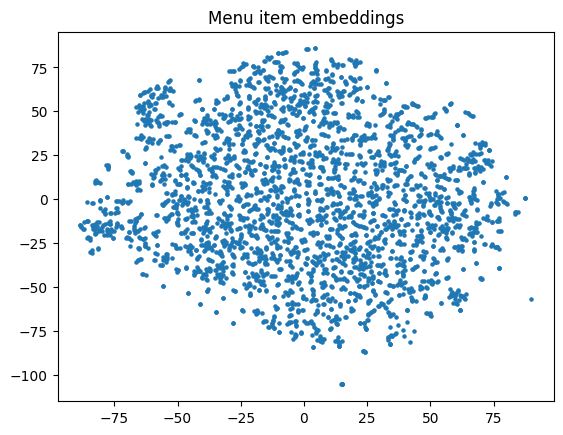

In [74]:
def visualize_embeddings(embeddings, size=10, labels=None, title=''):
    tsne = TSNE(n_components=2, learning_rate='auto', perplexity=5)
    tsne_embeddings = tsne.fit_transform(embeddings)

    plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], s=size, c=labels)
    plt.title(title)
    plt.show()

visualize_embeddings(embeddings, size=5, title='Menu item embeddings')

### Dimensionality reduction using PCA

เนื่องจาก Embedding shape มันมีหลายมิติ หรือมีจำนวนมิติมากเกินความจำเป็น ทำให้เราทดลองใช้ เทคนิคการลดมิติ เช่น PCA

โดยกำหนดให้เหลือ 90% ของ Variance ข้อมูล ที่ยอมรับได้

In [61]:
pca = PCA(n_components=0.9, svd_solver='full')
dim_reduced_embeddings = pca.fit_transform(embeddings)
print(f"Dimension reduced embedding shape: {dim_reduced_embeddings.shape}")

df[EMBEDDING] = list(dim_reduced_embeddings)

Dimension reduced embedding shape: (3500, 124)


### Vector Representation of topics

In [62]:
complaint_df = df.drop(columns=[COMPLAINT])
complaint_df = complaint_df.groupby(TOPIC).mean().reset_index()

In [63]:
complaint_df.head(5)

,topic,Embedding
0,Bank account or service,"[-0.81150264, 0.40370387, -1.0000875, 2.012812..."
1,Checking or savings account,"[-0.99776727, -0.3919225, -1.2612952, 1.810064..."
2,Consumer Loan,"[-0.96959454, 1.2321651, -0.429473, 0.7744161,..."
3,Credit card,"[-1.005779, 0.02622751, -0.31567067, 0.7481879..."
4,Credit card or prepaid card,"[-1.0177616, -0.27586758, -0.5104315, 1.109369..."


### หาเลข k ที่ดีที่สุดสำหรับการทำ K-means (number of clusters)

Use silhouette score (higher the better) to find the best k.

https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient

Silhouette scores: {5: 0.32917097, 6: 0.32179844, 7: 0.30711722, 8: 0.24329984, 9: 0.25192422, 10: 0.2531704, 11: 0.21872537, 12: 0.23194586, 13: 0.22647773, 14: 0.1827497, 15: 0.1413426, 16: 0.06782133}


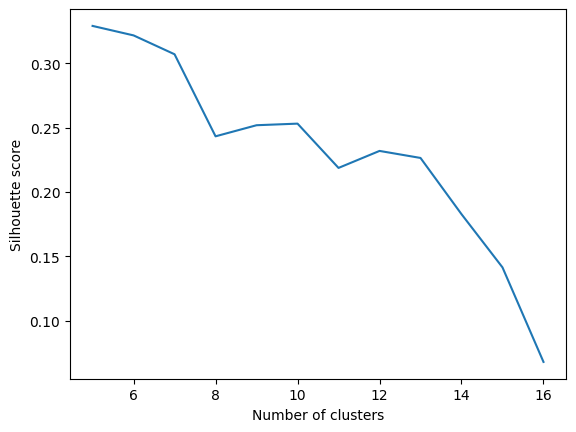

In [65]:
complaint_embeddings = [embedding for embedding in complaint_df[EMBEDDING].values]

candidate_k_values = list(range(5, 17))
slht_scores, kmeans_labels = [], []
for k in candidate_k_values:
    kmeans = KMeans(n_clusters=k, n_init=20)
    kmeans.fit(complaint_embeddings)

    kmeans_labels.append(kmeans.labels_)
    slht_scores.append(silhouette_score(complaint_embeddings, kmeans.labels_))

silhouette_score_dict = {candidate_k_values[i]: slht_scores[i] for i in range(len(slht_scores))}

print(f"Silhouette scores: {silhouette_score_dict}")

plt.plot(candidate_k_values, slht_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

จากกราฟจะสังเกตได้ว่า k = 5 จะทำให้ได้ค่า Sihouette Score สูงที่สุด ดังนั้นเราจะลอง Plot และ Visualize Clusters ด้วย k = 5

In [66]:
best_k = max(silhouette_score_dict, key=silhouette_score_dict.get)
print(f"The best k value for k-means is: {best_k}")

The best k value for k-means is: 5


In [67]:
test_complaint_df = complaint_df.copy()
test_complaint_df[CLUSTER] = kmeans_labels[candidate_k_values.index(best_k)]

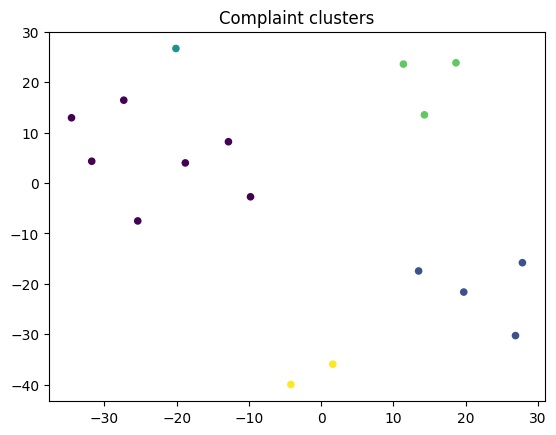

In [76]:
complaint_embeddings = np.array([embedding for embedding in test_complaint_df[EMBEDDING].values])

visualize_embeddings(complaint_embeddings, size=20, labels=test_complaint_df[CLUSTER].values, title='Complaint clusters')

In [77]:
test_complaint_df.sort_values(by=CLUSTER, inplace=True)
test_complaint_df.to_csv('complaints_clustered.csv', index=False, columns=[TOPIC, CLUSTER])

### Inspect clusters

Tried to look at what the most common words in the menu items for restaurants in each cluster are.

In [79]:
def most_common_words(x):
    word_salad = ' '.join(x.values).lower().split()
    ctr = Counter(word_salad)

    return ctr.most_common(3)

complaints_clustered_df = df.merge(test_complaint_df, on=TOPIC, how='left')
complaints_clustered_df.groupby(CLUSTER)[COMPLAINT].apply(most_common_words).reset_index()

,Cluster,input
0,0,"[(account, 1614), (card, 1020), (credit, 1009)]"
1,1,"[(loan, 1515), (mortgage, 899), (payment, 834)]"
2,2,"[(money, 23), (order, 16), (walmart, 9)]"
3,3,"[(credit, 4069), (account, 2237), (report, 2089)]"
4,4,"[(payment, 188), (credit, 154), (loan, 141)]"


### Cluster size ของ k = 5

Small Clusters คือ 2 ในขณะที่ Large Clusters คือ 0 และ 1

Text(0, 0.5, 'Cluster ID')

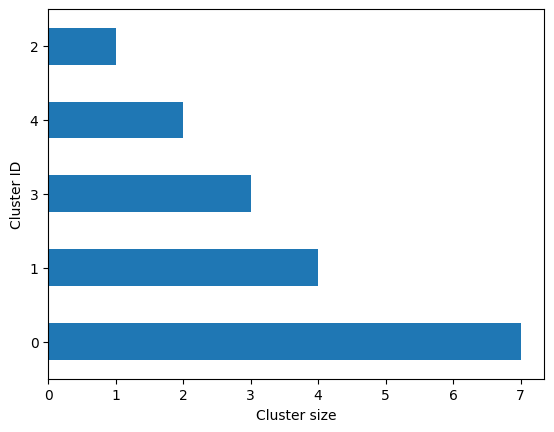

In [80]:
test_complaint_df[CLUSTER].value_counts().plot(kind='barh')
plt.xlabel('Cluster size')
plt.ylabel('Cluster ID')

---

### การทดลองที่ 2 : เปลี่ยนค่า k เป็น 10

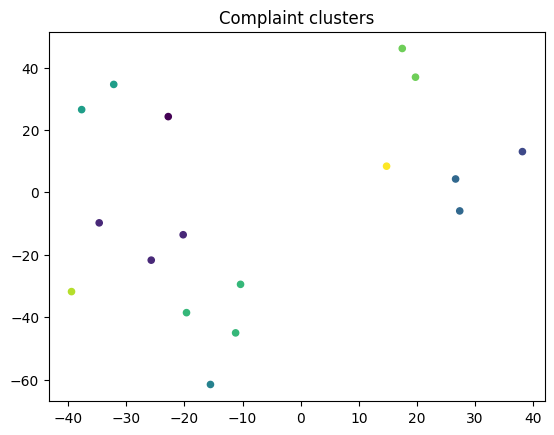

In [84]:
best_k = 10

k_ten_complaint_df = complaint_df.copy()
k_ten_complaint_df[CLUSTER] = kmeans_labels[candidate_k_values.index(best_k)]

complaint_embeddings = np.array([embedding for embedding in k_ten_complaint_df[EMBEDDING].values])

visualize_embeddings(complaint_embeddings, size=20, labels=k_ten_complaint_df[CLUSTER].values, title='Complaint clusters')

In [85]:
k_ten_complaint_df.sort_values(by=CLUSTER, inplace=True)
k_ten_complaint_df.to_csv('k_ten_complaints_clustered.csv', index=False, columns=[TOPIC, CLUSTER])

In [86]:
k_ten_complaints_clustered_df = df.merge(k_ten_complaint_df, on=TOPIC, how='left')
k_ten_complaints_clustered_df.groupby(CLUSTER)[COMPLAINT].apply(most_common_words).reset_index()

,Cluster,input
0,0,"[(debt, 1305), (credit, 920), (account, 688)]"
1,1,"[(credit, 820), (card, 809), (account, 705)]"
2,2,"[(loan, 981), (mortgage, 892), (payment, 554)]"
3,3,"[(loan, 149), (paid, 54), (pay, 54)]"
4,4,"[(money, 23), (order, 16), (walmart, 9)]"
5,5,"[(credit, 3149), (report, 1683), (account, 1549)]"
6,6,"[(account, 896), (bank, 649), (money, 299)]"
7,7,"[(payment, 188), (credit, 154), (loan, 141)]"
8,8,"[(card, 37), (money, 24), (would, 19)]"
9,9,"[(loan, 385), (payment, 231), (loans, 230)]"


Text(0, 0.5, 'Cluster ID')

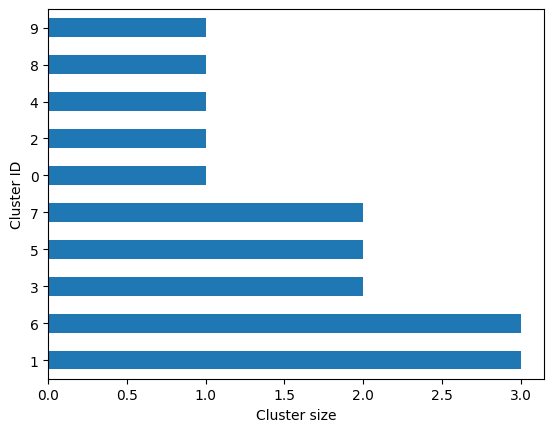

In [87]:
k_ten_complaint_df[CLUSTER].value_counts().plot(kind='barh')
plt.xlabel('Cluster size')
plt.ylabel('Cluster ID')

k = 10 เป็นตัวเลข k-means ที่ไม่ได้ประสิทธิภาพ เนื่องจากลองสังเกตกราฟแล้ว ความสำคัญและจำนวนของ Cluster มีเท่ากันทั้งหมด ดังนั้นหมายความว่าค่า k ที่เรากำหนดมีเยอะเกินความจำเป็นสำหรับข้อมูลนี้

## สรุปผลการทดลอง

จากการทดลองพบว่า k = 10 มีจำนวน Clusters ที่แบ่งเยอะเกินไป ทำให้ไม่สามารถ Represent Cluster ออกมาได้แม่นยำ และเนื่องจากข้อมูลขนาดน้อย  ไม่จำเป็นต้องแบ่งด้วยจำนวนเยอะขนาดเลข 10 ดังนั้น k = 5 น่าจะเป็นเลขที่เหมาะที่สุดสำหรับ Datasets ชุดนี้แล้ว ตามกราฟ Sihoulette Score

---

### ศวิษฐ์ โกสียอัมพร 65070507238